In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchtext==0.8.1
!pip install -U fastbook

     |████████████████████████████████| 7.0MB 8.3MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0
     |████████████████████████████████| 727kB 7.0MB/s 
     |████████████████████████████████| 1.2MB 19.1MB/s 
     |████████████████████████████████| 194kB 43.4MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 12.8MB 251kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled to

In [3]:
unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$',r'$\eta$',r'$\phi$' ]
branches=['E', 'pt', 'eta', 'phi']

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import fastbook
fastbook.setup_book()
from fastai.metrics import mse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from fastai import learner
from fastai.data import core
import time
from fastai.callback import schedule
import os
import numpy as np
from scipy import stats
import seaborn as sns

Mounted at /content/gdrive


In [9]:
%cd /content/drive/MyDrive/GSoC 21 CERN

/content/drive/MyDrive/GSoC 21 CERN


## Loading the Dataset

From the previous notebook, I had obtained pickled dumps of the cleaned dataset. The following cell loads it and gives info about it.

In [10]:
dataset_path = 'pickled_data/dataset.pkl'
dataset = pd.read_pickle(dataset_path)

print(dataset.head())
print("\n")
print('The number of entries in the dataset:', len(dataset))

          E        pt       eta       phi
0  5.412833  5.386811  0.065792  0.750047
1  5.716080  5.035790 -0.449460 -0.618930
2  5.583226  4.946480  0.429032 -0.652117
3  4.596681  4.548575  0.094092 -0.388150
4  5.353012  4.429400 -0.563216 -0.753127


The number of entries in the dataset: 22661


# Correlation

Intuitively, it is apparent that if we want our model to be able to restore original data, after having transformed it into something much smaller, it would be better if some variables correlate with each other. 
The following cell tests this by calculating correlation and plotting a correlation heatmap.

            E        pt       eta       phi
E    1.000000  0.754721 -0.008959  0.000143
pt   0.754721  1.000000 -0.007037 -0.003686
eta -0.008959 -0.007037  1.000000  0.005108
phi  0.000143 -0.003686  0.005108  1.000000




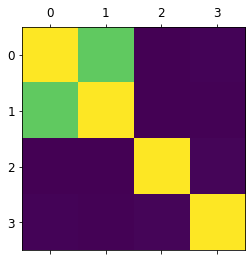

In [11]:
print(dataset.corr())
print("\n")
plt.matshow(dataset.corr())
plt.show()

There is good amount of correlation between E and pt, visible from the above output.

# Normalisation

All the 4 variables by virtue of being different physical quantities have different units. By normalising them, it would be easier for the model to converge faster and to a stable minima for loss.

In [12]:
x = dataset.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_norm=pd.DataFrame(x_scaled, columns=dataset.columns)

Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

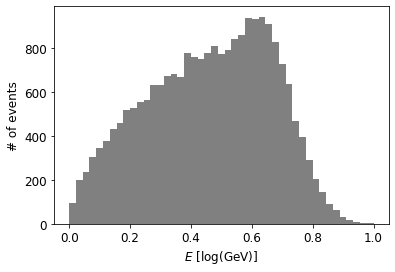

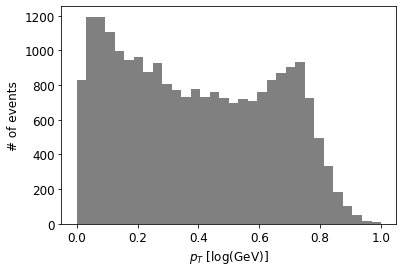

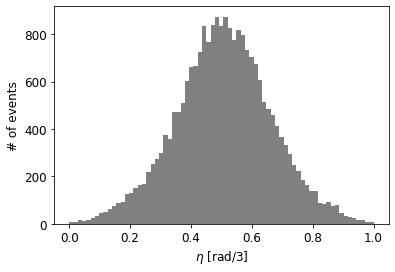

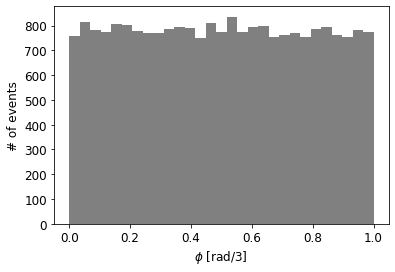

In [13]:
def plot_dataset(dataset):
  for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(dataset[branches[kk]], color='gray', label='Input', alpha=1, bins='auto')
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

plot_dataset(dataset_norm)

## Train-Val-Test Split and Dataloaders



The dataset is of nearly 22k samples making a 90-10-10 split useful to train and then test the model's performance.


In [14]:
train, test = train_test_split(dataset_norm, test_size=0.2)
test, val = train_test_split(test, test_size=0.5)

train_x = train
test_x = test
train_y = train_x  
test_y = test_x
val_x = val
val_y = val_x

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
test_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))
val_ds = TensorDataset(torch.tensor(val_x.values, dtype=torch.float), torch.tensor(val_y.values, dtype=torch.float))

bs = 256

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [15]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [16]:
loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.004786301031708717
Learning rate with the steepest gradient: 0.0004786300996784121


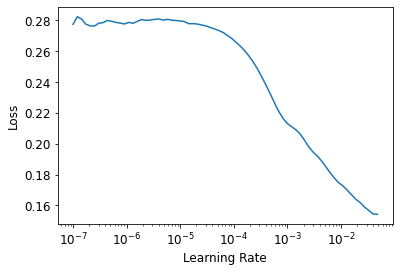

In [17]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once 
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [18]:
start = time.perf_counter() 
learn.fit_one_cycle(n_epoch=150,lr_max=lr_min)
end = time.perf_counter() 
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.059387,0.031539,00:00
0,0.059387,0.031539,00:00
1,0.027217,0.011183,00:00
1,0.027217,0.011183,00:00
2,0.013614,0.009968,00:00
2,0.013614,0.009968,00:00
3,0.009938,0.008769,00:00
3,0.009938,0.008769,00:00
4,0.006060,0.003983,00:00
4,0.006060,0.003983,00:00


Training took 117.36424056100003 seconds


Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

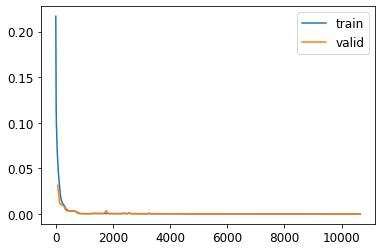

In [19]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [20]:
learn.validate()

(#1) [6.708976911795617e-07]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [21]:
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [22]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    return df

# Histograms using Test Data

Histograms for Test and Predicted Test are imposed over each other for each variable.

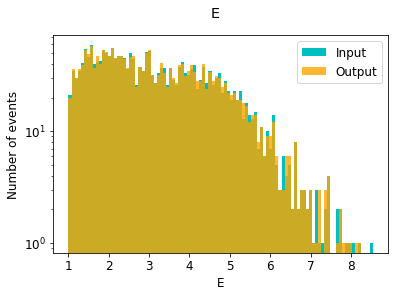

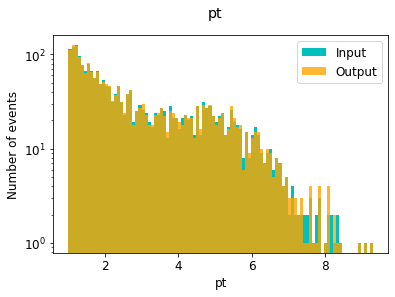

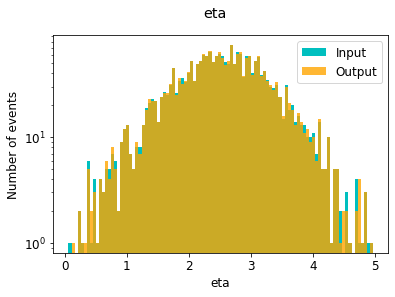

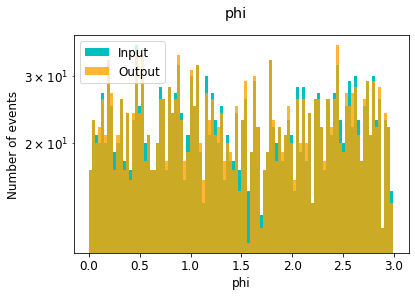

In [23]:
plt.close('all')
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True 
 
data = torch.tensor(test[:].values, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 100
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

# Analysis on the Residual Error

In [24]:
residuals = (unnormalized_pred_df - unnormalized_data_df)/unnormalized_data_df
residuals.head()

,E,pt,eta,phi
0,0.001901,-0.001664,-0.000974,-0.000569
1,0.001488,-0.000410,0.000346,-0.001002
2,0.000833,-0.003783,-0.000491,-0.000304
3,0.001953,-0.002445,-0.000501,0.000522
4,-0.000464,-0.000690,0.001026,0.003270


## Average Absolute Error

In [25]:
for branch in branches:
  print("For "+branch)
  print(f"Average Absolute Error is: {np.sum(np.abs(residuals[branch]))/len(residuals)}")
  print(f"{100-np.sum(np.abs(residuals[branch]))/len(residuals)*100}% Data was recovered")
  print("\n")

For E
Average Absolute Error is: 0.0015812253699508895
99.8418774630049% Data was recovered


For pt
Average Absolute Error is: 0.0016458778389764905
99.83541221610236% Data was recovered


For eta
Average Absolute Error is: 0.0014150752920233246
99.85849247079767% Data was recovered


For phi
Average Absolute Error is: 0.027177307317452628
97.28226926825474% Data was recovered




## Pair Plot

From this plot we can understand which variables are most likely to be erroneouly decoded together. Thankfully, the only case in which 2 variables have high residue together is of E and pt, which is expected due to their high correlation we had observed earlier.

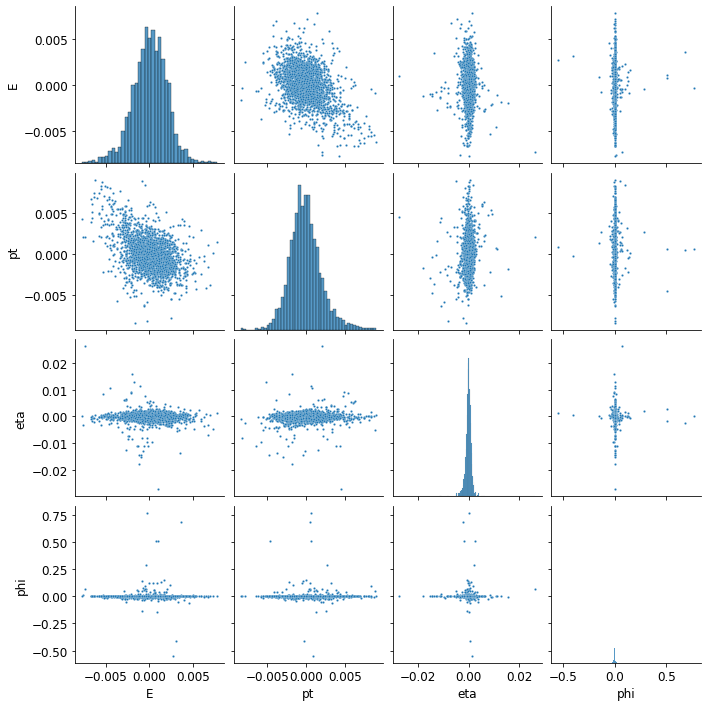

In [26]:
residuals=residuals[(np.abs(stats.zscore(residuals)) < 4).all(axis=1)]
sns.pairplot(pd.DataFrame(residuals), kind="scatter", diag_kind="hist", plot_kws={'s':5})

In [27]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)

# Relative Error by bins

Average Error: 0.0005434938105632893


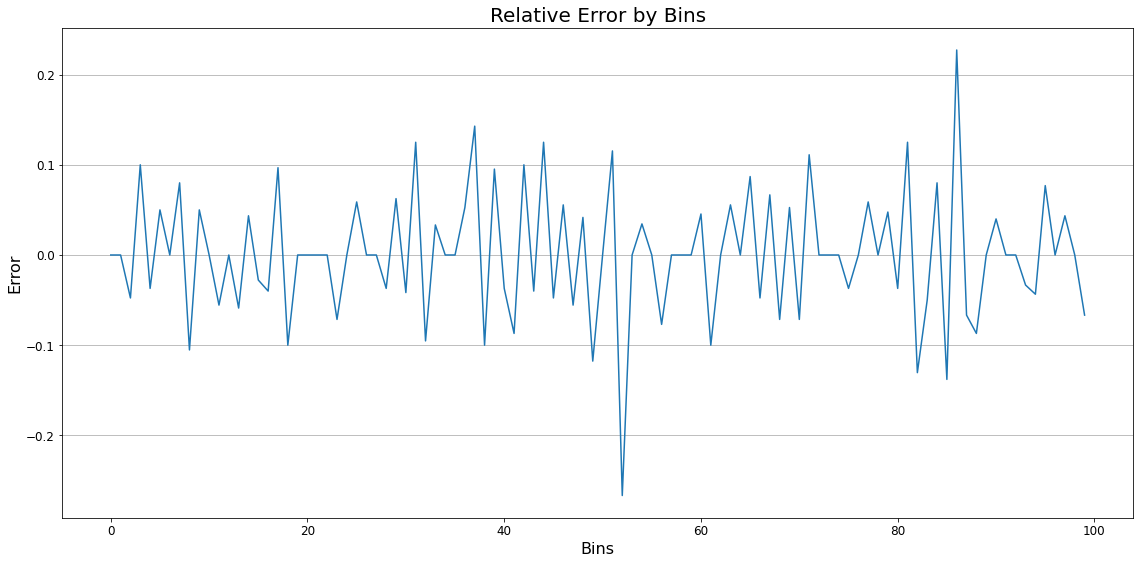

In [28]:
rat = getRatio(n_hist_data,n_hist_pred)

print(f'Average Error: {np.mean(rat)}')

plt.figure(figsize=[16,8])
plt.plot(rat)
plt.xlabel('Bins', size=16)
plt.ylabel('Error', size=16)
plt.title("Relative Error by Bins", size=20)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("relativeerror", bbox_inches='tight', dpi = 300)
plt.show()